whole people
system(int state, beta, gamma)
timefreame for schedule
run simulation (sys, sch)
    create results
    for t to t end
        get new beta
        update
        add to results
    return results

In [1]:
%matplotlib inline

from modsim import *
from pandas import read_excel
import math

In [2]:
filename = "data/project2.xlsx"
table = read_excel(filename, header = 0, index_col = 0, sheetname = 'Sheet2')
filename2 = "data/project2survey.xlsx"
tableSurvey = read_excel(filename2, header = 0, index_col = 0)
#The first file is our chosen values, the second file is the survey data

In [3]:
table.columns = ['beta']
tableSurvey.columns = ['numSick', 'percentSick']
#Dunno how the survey data is actually going to be formatted, so this is subject to change

In [4]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=349, I=10, R=0) #Upperclassmen arrived in the same week as freshmen this year, 
    init /= sum(init)             #so we can't really model it due to our time steps
    init.I = 0.07

    t0 = 1 #The chosen table starts at 1
    t_end = 8 * 7 #And ends at 39, but t + 1

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

In [5]:
tc = 3      # time between contacts in days 
tr = 8      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

pop = make_system(beta, gamma)
popFixedBeta = make_system(beta, gamma)

In [6]:
def updateVaryBeta(state, system, t, table):
    """Update the SIR model with varying beta.
    
    state: State with variables S, I, R
    system: System with beta and gamma
    t: Int representing current week
    table: DataTable of beta values
    
    returns: State object
    """
    s, i, r = state
    
    system.beta = update_beta(math.ceil(t/7), table) #Moved the varying of beta to the update function

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

In [7]:
def update(state, system, t, table):
    """Update the SIR model without varying beta.
    
    state: State with variables S, I, R
    system: System with beta and gamma
    t: Int representing current week
    table: DataTable of beta values
    
    returns: State object
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

In [8]:
def update_beta(n, schedule):
    """Generates a new beta for the current week
    n: Integer, representing week number
    schedule: DataTable of beta values
    """
    beta = schedule.beta[n] + 0.08 #Added because the winter break is long enough that all diseases die out, which screws with the model
    return beta

In [9]:
def run_simulation(system, update_func, table):
    """Runs a simulation of the system.
    
    Add a DataFrame to the System: results
    
    system: System object
    update_func: function that updates state
    table: A DataTable of time and data
    """
    frame = DataFrame(columns=system.init.index)
    frame.loc[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end):
        frame.loc[t+1] = update_func(frame.loc[t], system, t, table)
    
    system.results = frame

In [10]:
def plot_results(system1, system2, series3):
    """Plots the results of the system.
    
    system: System object
    """
    newfig()
    plot(system1.results.I, "r-", label = "Varying Beta")
    plot(system2.results.I, "b-", label = "Fixed Beta")
    plot((series3.index * 7) - 6, series3.percentSick, 'g-', label = "Survey")
    decorate(xlabel = "Time (Days)",
            ylabel = "Fraction of Population",
            title = "Fraction Infected")

In [11]:
def plotDifference(series1, series2, series3):
    """Plots the difference between series1 and series2 and series1 and series3
    
    series1: A TimeSeries of data
    series2: A TimeSeries of data
    """
    newfig()
    result = TimeSeries()
    for t in series1.index:
        result[t] = series1[t] - series2[(t * 7) - 6] #Creates a TimeSeries where the elements are the differences in the two series
    plot(result, 'r-', label = "Varying Beta")
    result2 = TimeSeries()
    for t in series1.index:
        result2[t] = series1[t] - series3[(t * 7) - 6]
    plot(result2, 'b-', label = "Fixed Beta")
    decorate(xlabel = "Time (Weeks)",
            ylabel = "Error",
            title = "Error between Models and Data")

In [12]:
def getAverageDifference(series1, series2):
    """Takes the average difference of the elements in series1 and series2
    
    series1: A TimeSeries of data
    series2: A TimeSeries of data
    """
    result = 0
    for t in series1.index: 
        result += abs(series1[t] - series2[(t * 7) - 6]) #Takes the difference in each of the elements of the series and sums them
    result = result / series1.index.size #Apparently, this is how you get the number of elements in an index?
    return result

In [13]:
run_simulation(pop, updateVaryBeta, table)
run_simulation(popFixedBeta, update, table)

C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


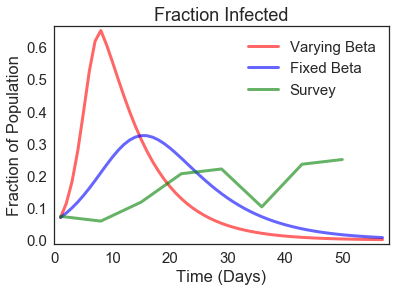

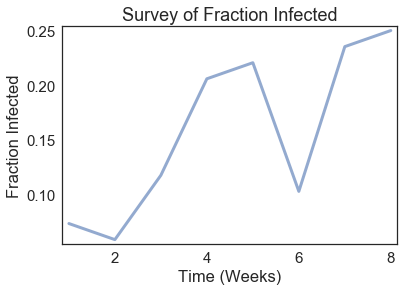

In [14]:
plot_results(pop, popFixedBeta, tableSurvey)
newfig()
plot(tableSurvey.percentSick)
decorate(xlabel = "Time (Weeks)", ylabel = "Fraction Infected", title = "Survey of Fraction Infected")

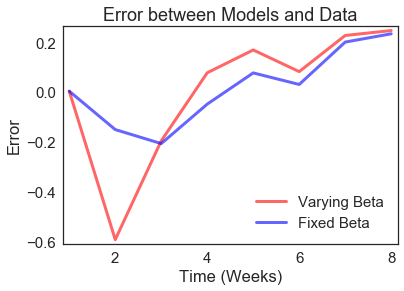

In [15]:
plotDifference(tableSurvey.percentSick, pop.results.I, popFixedBeta.results.I)

In [16]:
print(getAverageDifference(tableSurvey.percentSick, pop.results.I))
print(getAverageDifference(tableSurvey.percentSick, popFixedBeta.results.I))

0.199001747627
0.118743526935


In [17]:
print(table.beta)

Week #
1     0.70
2     0.40
3     0.40
4     0.40
5     0.60
6     0.60
7     0.33
8     0.40
9     0.25
10    0.25
11    0.25
12    0.25
13    0.00
14    0.40
15    0.25
16    0.25
17    0.10
18    0.00
19    0.00
20    0.00
21    0.00
22    0.00
23    0.40
24    0.25
25    0.25
26    0.25
27    0.50
28    0.50
29    0.50
30    0.00
31    0.40
32    0.25
33    0.25
34    0.25
35    0.25
36    0.25
37    0.20
38    0.30
Name: beta, dtype: float64
